# Inference 

---

The inference is created from 3 parts - face detector, spectrum translator from NIR to VIS and vice versa, and Facial expression recognition part.

### Face Detector
Now, face detection can be done with 2 following models:
* **RetinaFace** - model from [here](https://github.com/serengil/deepface). Accurate, though less quick. Also, RetinaFace can align the face.
* **CenterFace** - original Centerface from [here](https://gitlab.fit.cvut.cz/vadlemar/real-time-facial-expression-recognition-in-the-wild). It is fast, however less accurate than first one. The model in onnx is stored in `models/pretrained/centerface.onnx`. This option does not implicitly align faces in Inference class, RetinaFace does.

Additional detectors from DeepFace module can be easily added such as *MTCNN* or *Jones-Viola* algorithm.

### Spectrum Translator
Translates images between NIR, VIS specters.

* **CycleGAN on CASIA+OuluCasia db** - This Translates between both specters. 
* **FFE-CycleGAN on BUAA db** - This translates between NIR images and averaged grayscale image (averaged from color green illuminated RGB image). The translation is good, however not 

### Facial expression recognition
Classifies categorical emotion and regresses the valece arousal labels. 
* **MobileNet** - FER net from original work [here](https://github.com/serengil/deepface). Does not work on NIR. Onnx in `models/pretrained/mobilenet_simultaneous.onnx`.
* **MobileNet-NIR** - Original MobileNet pretrained on Oulu-Casia database NIR images. Several onnx versions are stored in a folder `models/mobilenet_NIR/`. Additional information below.

***

#### MobileNet-NIR on Oulu-Casia db
This was pretrained on original mobilenet facial expression recognition model.
It has both categorical and spatial predictions.

It was pretrained on 7 emotions (neutral, anger, disgust, fear, happy, sad, surprise) - without contempt unlike in original model.


Since this dataset the model was pretrained on did not have valence arousal labels (only categorical), they were assigned in following way. Because dataset contained for each emotion (for each patient) images retrieved from video, that started from neutral to most affected emotion. according to this gradient were linearly assigned valence arousal values.

The most affected categorical emotions are anchored to following V/A values:

* neutral: (0., 0.),
* anger: (-0.51, 0.59),
* disgust: (-0.60, 0.35),
* fear: (-0.64, 0.6),
* happiness: (0.81, 0.51),
* sadness: (-0.63, -0.27),
* surprise: (0.4, 0.67)

Above VA labels are from [-1, 1] and are not recalculated from circumplex model yet.
But model can be quickly trained, and now is only pretrained on 15 epochs.

## Definitions

Imports

In [1]:
from lightning.pytorch import Trainer

from skeleton.data.oulu_casia import OuluCasiaDataModule
from skeleton.models.CycleGAN import CycleGAN

from lightning.pytorch.loggers import TensorBoardLogger

import cv2
import onnx

from typing import Optional, Union, List
import onnxruntime as ort
from deepface import DeepFace
import numpy as np

import datetime
from skeleton.models import CycleGAN, DenseUnetGAN
from skeleton.models.utils import (
    create_folder,
    load_images_from_folder,
    save_tensor_images,
)
from skeleton.inference import *
import os
from PIL import Image
from torchvision import transforms

from enum import Enum
import onnx

from pathlib import Path

import glob


import math
import numpy as np

import pathlib

import gc

2024-02-04 10:32:52.772993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 10:33:01.086175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Definitions of inference classes of individual networks and one encapsulating inference class.

## Inference examples

***

The inference first needs defining each of: *face detector*, *spectrum translator* and *facial expression recognition* (FER). Each one of them needs either `"net_type": None` for skipping this part, or defining the model type with its path to onnx file and additional info.
This models definition are shown below and further passed to Inference object.

Model types can be for:
* **Face detector** - `Inference.net_type.FACE_DETECTOR_CENTERFACE` or `Inference.net_type.FACE_DETECTOR_RETINAFACE`
* **FER** - `Inference.net_type.FER_MOBILENET`
* **Spectrum translation** - `Inference.net_type.SPECTRUM_TRANSLATOR_FFE_CYCLEGAN` or
`Inference.net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN`

In [2]:
# define here which models to use. If u which not to use certain model, set its 'net_type' = None.
# If you want to apply model, pick from Inference.net_type defined above
models = {
    "face_detector": {
        "net_type": None, # Inference.net_type.FACE_DETECTOR_RETINAFACE,
    },
    "spectrum_translator": {
        "net_type": Inference.net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN,
        "pth_to_onnx": 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx',
        # First translates input image to grayscale and then trnaslates spectra
        # can be used as VIS grayscale <-> NIR translation
        "input_as_avg_grayscale": False,
        # translates newly translated image to averaged grayscale. 
        # Useful when grayscale 3-channel images create artefacts.
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx",
        # translates Valence/Arousal labels from [-1,1] domain to
        # cicrumplex model, since MobileNets are in domain [-1, 1].
        "va_to_circumplex_model": True,
    }
}

# debug flag is displaying images, verbose prints other secondary information
inf = Inference(models, None, verbose=True, debug=True)

Using '{'net_type': <net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN: 'B'>, 'pth_to_onnx': 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx', 'input_as_avg_grayscale': False, 'output_as_avg_grayscale': True}' as spectrum transfer model


NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx failed:Load model models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx failed. File doesn't exist

After the `Inference` object definition, the inference can be run. Either *from_folder* loading images, *from_filenames* loading images from array of filepaths, or *from_array* - already loaded image as np.array.

Also the inference can be run as *infer_instant* where each image is immediately passed through all parts of Inference, as opposed to *infer* mode, where are first all images detected, then than those translated and then FER.

Thus following functions are available:
* `inf.infer_from_folder('path/to/folder')`
* `inf.infer_from_filenames(['path/to/image1', 'path/to/image2'])`
* `inf.infer_from_array(img_np_array)`

And for Inference of each image separately is:
* `inf.infer_instant_from_folder('path/to/folder', save_to_folder='pth/to/save_fld')`
* `inf.infer_instant_from_filenames(['path/to/image1', 'path/to/image2'], save_to_folder='pth/to/save_fld')`
* `inf.infer_instant_from_array(img_np_array, save_to_folder='pth/to/save_fld')`
Also, 

helper function:
* `save_images_to_folder`

In [ ]:
output = inf.infer_instant_from_folder('data/AffectNet-8Labels/train_set/images_small/')

When infering the NIR images - detecting them and subsequently clasify expressions. it predicts better when balck stripes are on sides of image and is not purely resized.

Using '{'net_type': <net_type.FACE_DETECTOR_CENTERFACE: 'F'>, 'remove_black_stripes': True, 'display_images': True}' as face detector model
data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_001.bmp
cpu times =  0:00:00.071325


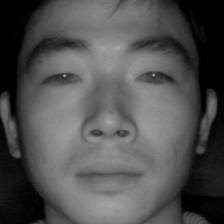

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_002.bmp
cpu times =  0:00:00.069202


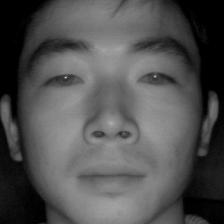

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_003.bmp
cpu times =  0:00:00.060992


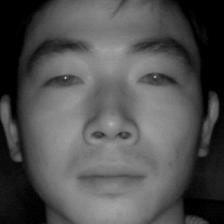

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_004.bmp
cpu times =  0:00:00.080827


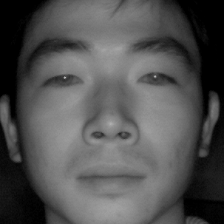

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_005.bmp
cpu times =  0:00:00.077329


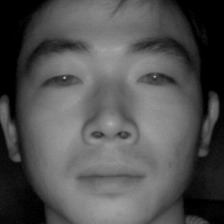

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_006.bmp
cpu times =  0:00:00.050282


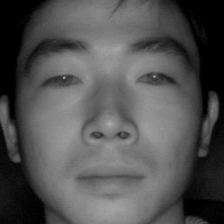

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_007.bmp
cpu times =  0:00:00.060302


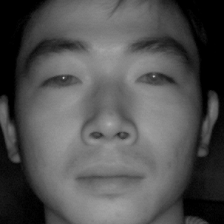

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_008.bmp
cpu times =  0:00:00.069790


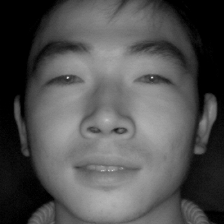

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00001_009.bmp
cpu times =  0:00:00.063587


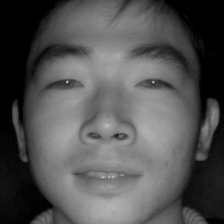

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_001.bmp
cpu times =  0:00:00.057643


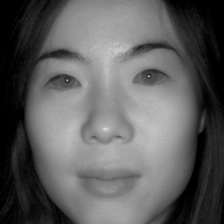

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_002.bmp
cpu times =  0:00:00.059371


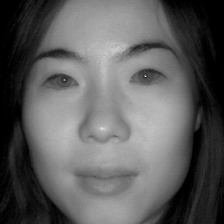

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_003.bmp
cpu times =  0:00:00.067024


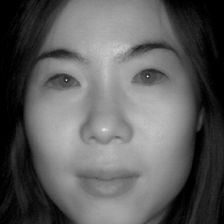

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_004.bmp
cpu times =  0:00:00.064000


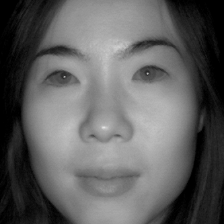

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_005.bmp
cpu times =  0:00:00.061471


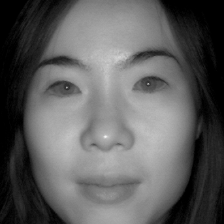

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_006.bmp
cpu times =  0:00:00.056257


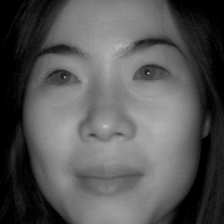

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_007.bmp
cpu times =  0:00:00.067857


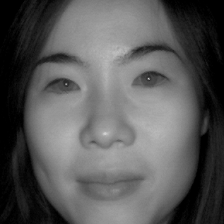

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_008.bmp
cpu times =  0:00:00.067827


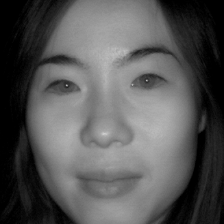

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_009.bmp
cpu times =  0:00:00.067449


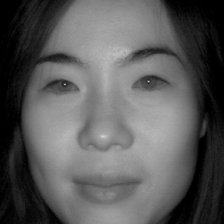

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00002_010.bmp
cpu times =  0:00:00.061033


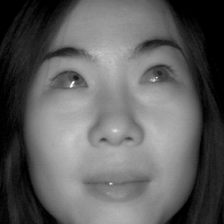

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_001.bmp
cpu times =  0:00:00.060723


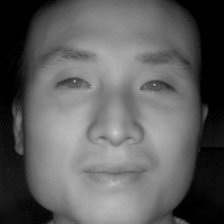

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_002.bmp
cpu times =  0:00:00.050795


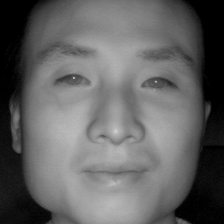

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_003.bmp
cpu times =  0:00:00.067479


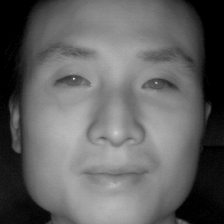

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_004.bmp
cpu times =  0:00:00.065380


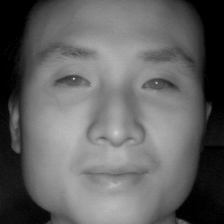

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_005.bmp
cpu times =  0:00:00.056998


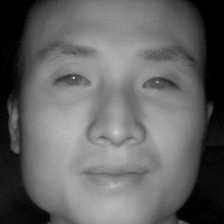

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_006.bmp
cpu times =  0:00:00.048670


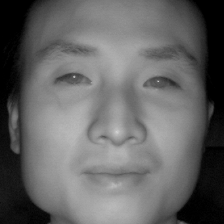

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_007.bmp
cpu times =  0:00:00.051437


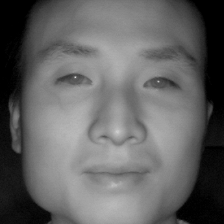

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_008.bmp
cpu times =  0:00:00.066238


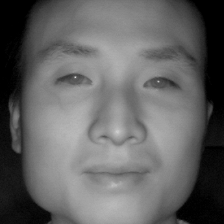

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_009.bmp
cpu times =  0:00:00.067182


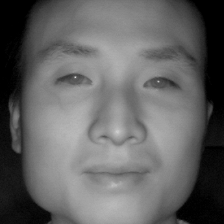

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_010.bmp
cpu times =  0:00:00.069280


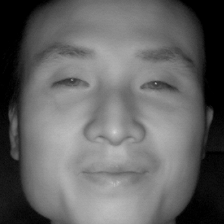

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00003_011.bmp
cpu times =  0:00:00.058410


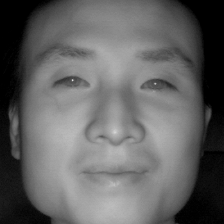

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_001.bmp
cpu times =  0:00:00.047916


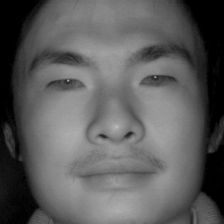

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_002.bmp
cpu times =  0:00:00.081866


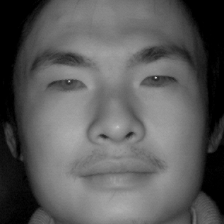

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_003.bmp
cpu times =  0:00:00.067673


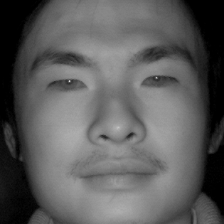

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_004.bmp
cpu times =  0:00:00.072096


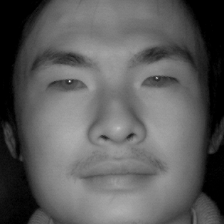

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_005.bmp
cpu times =  0:00:00.075636


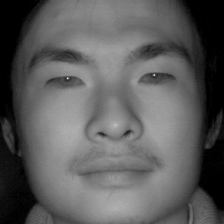

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_006.bmp
cpu times =  0:00:00.080080


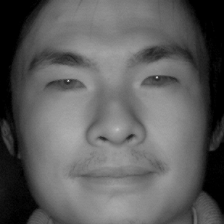

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_007.bmp
cpu times =  0:00:00.047368


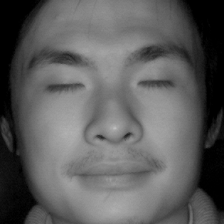

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_008.bmp
cpu times =  0:00:00.052313


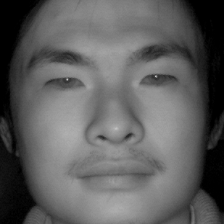

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00004_009.bmp
cpu times =  0:00:00.070113


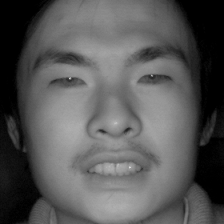

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_001.bmp
cpu times =  0:00:00.061881


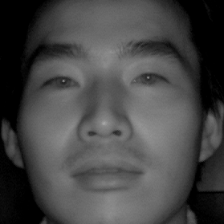

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_002.bmp
cpu times =  0:00:00.080950


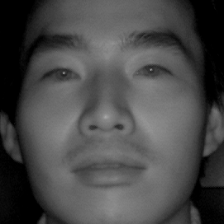

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_003.bmp
cpu times =  0:00:00.055568


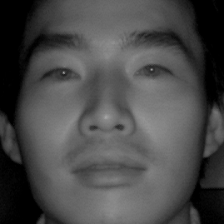

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_004.bmp
cpu times =  0:00:00.062842


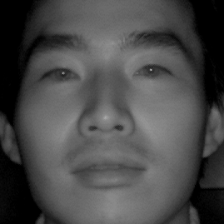

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_005.bmp
cpu times =  0:00:00.068491


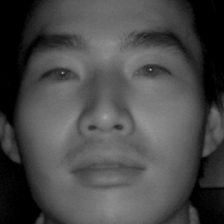

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_006.bmp
cpu times =  0:00:00.068890


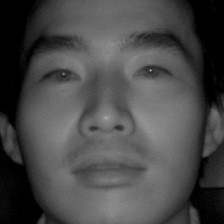

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_007.bmp
cpu times =  0:00:00.061185


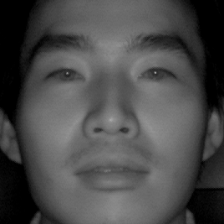

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_008.bmp
cpu times =  0:00:00.059265


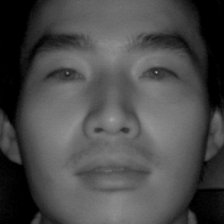

data/CASIA_NISVIR/NIR-VIS/NIR-small/s1_NIR_00005_009.bmp
cpu times =  0:00:00.055239


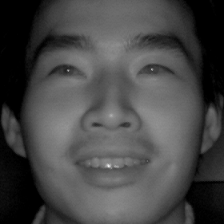

In [3]:
# define here which models to use. If u which not to use certain model, set its 'net_type' = None.
# If you want to apply model, pick from Inference.net_type defined above
models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_CENTERFACE, # Inference.net_type.FACE_DETECTOR_RETINAFACE,
        "remove_black_stripes": True,
        "display_images": True,
    },
    "spectrum_translator": {
        "net_type": None,#Inference.net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN,
        "pth_to_onnx": 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx',
        # First translates input image to grayscale and then trnaslates spectra
        # can be used as VIS grayscale <-> NIR translation
        "input_as_avg_grayscale": False,
        # translates newly translated image to averaged grayscale. 
        # Useful when grayscale 3-channel images create artefacts.
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": None, # Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx",
        # translates Valence/Arousal labels from [-1,1] domain to
        # cicrumplex model, since MobileNets are in domain [-1, 1].
        "va_to_circumplex_model": True,
    }
}

# debug flag is displaying images, verbose prints other secondary information
inf = Inference(models, None, verbose=True, debug=True)

output = inf.infer_instant_from_folder('data/CASIA_NISVIR/NIR-VIS/NIR-small/')

## Test on MobilNet-NIR - AffectNet-NIR

In [5]:
models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_RETINAFACE,
    },
    "spectrum_translator": {
        "net_type": None, 
        "pth_to_onnx": 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx',
        "input_as_avg_grayscale": False,
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_on_AffectNet-NIR/mobilenet_aff_nir-aff_continue.onnx",
        "va_to_circumplex_model": False,
    }
}
inf = Inference(models, None, verbose=True, debug=True)

Using '{'net_type': <net_type.FACE_DETECTOR_RETINAFACE: 'G'>}' as face detector model
Using '{'net_type': <net_type.FER_MOBILENET: 'E'>, 'pth_to_onnx': 'models/mobilenet_NIR/mobilenet_on_AffectNet-NIR/mobilenet_aff_nir-aff_continue.onnx', 'va_to_circumplex_model': False}' as FER model
model 'models/mobilenet_NIR/mobilenet_on_AffectNet-NIR/mobilenet_aff_nir-aff_continue.onnx' loaded


### Test by eye on unseen Oulu-Casia db

In [ ]:
inf.infer_instant_from_folder("data/all_affected_nir_images_from_buaa/")

## Tests on MobileNet-NIR - Oulu-Casia

In [16]:
models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_RETINAFACE,
    },
    "spectrum_translator": {
        "net_type": None, 
        "pth_to_onnx": 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-latestepoch.onnx',
        "input_as_avg_grayscale": False,
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_on_oulucasia/mobilenet_aff_nir-oulu-bigger_split_strategy2-scheduler_from_5e-4.onnx",#mobilenet_NIR-19ep_scheduler.onnx",
        "va_to_circumplex_model": False,
    }
}
inf = Inference(models, None, verbose=False, debug=True)

Using '{'net_type': <net_type.FACE_DETECTOR_RETINAFACE: 'G'>}' as face detector model
Using '{'net_type': <net_type.FER_MOBILENET: 'E'>, 'pth_to_onnx': 'models/mobilenet_NIR/mobilenet_on_oulucasia/mobilenet_aff_nir-oulu-bigger_split_strategy2-scheduler_from_5e-4.onnx', 'va_to_circumplex_model': False}' as FER model
model 'models/mobilenet_NIR/mobilenet_on_oulucasia/mobilenet_aff_nir-oulu-bigger_split_strategy2-scheduler_from_5e-4.onnx' loaded


### Test by eye on test set

In [ ]:
inf.infer_instant_from_folder("data/F_PreprocImg/NI/Strong/test/")

### Test by eye on unseen BUAA db

In [ ]:
inf.infer_instant_from_folder("data/all_affected_nir_images_from_buaa/")

### Test on custom db by eye

In [ ]:
inf.infer_instant_from_folder("data/all_affected_nir_images_from_buaa/")

In [ ]:
inf.infer_instant_from_folder("data/Custom_DB/custom_test_set_highres_filtered/")

## Tests on FFE-CycleGAN - NIR<->gray VIS translation

### VIS gray -> NIR

In [106]:
models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_RETINAFACE,
    },
    "spectrum_translator": {
        "net_type": Inference.net_type.SPECTRUM_TRANSLATOR_FFE_CYCLEGAN, 
        "pth_to_onnx": './models/ffe-cyclegan/on_buua_gray_w_and_ wo_stripes/model_GA_10.onnx',
#         "pth_to_onnx": './models/ffe-cyclegan/on_buaa_gray/ffe_buaa_gray-B-150.onnx',
        "input_as_avg_grayscale": True,
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx",
        "va_to_circumplex_model": True,
    }
}
inf = Inference(models, None, verbose=True, debug=True)

Using '{'net_type': <net_type.FACE_DETECTOR_RETINAFACE: 'G'>}' as face detector model
Using '{'net_type': <net_type.SPECTRUM_TRANSLATOR_FFE_CYCLEGAN: 'A'>, 'pth_to_onnx': './models/ffe-cyclegan/on_buua_gray_w_and_ wo_stripes/model_GA_10.onnx', 'input_as_avg_grayscale': True, 'output_as_avg_grayscale': False}' as spectrum transfer model
FFE-CycleGAN model from './models/ffe-cyclegan/on_buua_gray_w_and_ wo_stripes/model_GA_10.onnx' loaded.
Using '{'net_type': <net_type.FER_MOBILENET: 'E'>, 'pth_to_onnx': 'models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx', 'va_to_circumplex_model': True}' as FER model
model 'models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx' loaded


#### On unseen AffectNet

In [ ]:
o = inf.infer_instant_from_folder('data/AffectNet-8Labels/train_set/images_small/')

## Tests on Original CycleGAN NIR<->VIS translation

In [7]:
models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_CENTERFACE,
    },
    "spectrum_translator": {
        "net_type": Inference.net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN, 
        "pth_to_onnx": './models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-latestepoch.onnx',
#         "pth_to_onnx": './models/cyclegan-snellius/cyclegan-snellius-ouluvl-GA-latestepoch.onnx',
        "input_as_avg_grayscale": False,
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": None,#Inference.net_type.FER_MOBILENET,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_NIR-19ep_scheduler.onnx",
        "va_to_circumplex_model": True,
    }
}
inf = Inference(models, None, verbose=False, debug=False)

Using '{'net_type': <net_type.FACE_DETECTOR_CENTERFACE: 'F'>}' as face detector model
Using '{'net_type': <net_type.SPECTRUM_TRANSLATOR_ORIG_CYCLEGAN: 'B'>, 'pth_to_onnx': './models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-latestepoch.onnx', 'input_as_avg_grayscale': False, 'output_as_avg_grayscale': True}' as spectrum transfer model
Orig-CycleGAN model from './models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-latestepoch.onnx' loaded.


### On unseen data from AffectNet

In [ ]:
# o = inf.infer_instant_from_folder('data/AffectNet-8Labels/train_set/images/', 'data/Affectnet_in_NIR/train_set/images/')